![MOSEK ApS](https://www.mosek.com/static/images/branding/webgraphmoseklogocolor.png )


## Risk Parity Portfolio Selection using MOSEK Optimizer API


Portfolio selection (or portfolio management) is the art and science of making decisions about investment mix and policy, matching investments to objectives, asset allocation for individuals and institutions, and balancing risk against performance.

This tutorial demonstrates the use of exponential cones in modeling logarithmic terms using Python Fusion. It is largerly based on Bai, X., Scheinberg, K., Tutuncu, R. (2013), Least-squares approach to risk parity in portfolio selection. We assume basic familiarity with the Markowitz risk-return model.

# Risk Parity

Consider the problem of investing in $n$ different assets. Let $x_i$ be the percentage of money invested in assets $i$, and $\mu_i$ its expected return. Let assume we know the covariance matrix $\Sigma$ that link the assets together. We can then define two global measures of the portfolio performance, expected return:

$$
\mu =\sum_{i=1}^n \mu_i x_i, 
$$

and risk:

$$
\sigma^2 = \sum_{i=1}^n \sum_{j=1}^n \Sigma_{i,j}x_i x_j = x^T \Sigma x.
$$

For different choices of $x_i$ the investor will get different combinations of $\mu$ and $\sigma^2$. The set of all possible ($\sigma^2$, $\mu$) combinations is called the $\textit{attainable set}$. The theory assumes that investors prefer to minimize risk: given the choice of two portfolios with equal returns, investors will choose the one with the least risk.

In a fully-invested portfolio, every asset $i$ has a contribution in terms of risk. Let $RC_i(x)$ be this contribution, we have that the total risk of the invested portfolio is:

$$
\mathcal{R}(x) = \sum_{i=1}^n RC_i(x)
$$

where

$$
RC_i(x) = x_i \frac{\partial \mathcal{R}(x)}{\partial x_i}
$$

Let $b=(b_1,..,b_n)$ be a vector of $\textbf{budgets}$ such as $b_i > 0$ and $\sum_{i=1}^n b_i = 1$. We define a **risk parity** (or risk budgeting) portfolio as the solution of the following set of equations:

$$
\begin{aligned}
&\begin{cases}
RC_1(x) = b_1 \mathcal{R}(x)\\
..\\
RC_i(x) = b_i \mathcal{R}(x)\\
..\\
RC_n(x) = b_n \mathcal{R}(x)
\end{cases}
\end{aligned}
$$

From the above equations, we can write the risk parity constraint as:

$$
\frac{x_i}{b_i} \frac{\partial \mathcal{R}(x)}{\partial x_i} = \frac{x_j}{b_j} \frac{\partial \mathcal{R}(x)}{\partial x_j} \hspace{1em} \forall i,j
$$

The Risk Parity portfolio requires that each asset has the same total contribution to risk, that is:

$$
\begin{aligned}
&\frac{x_i}{b_i} \frac{\partial \mathcal{R}(x)}{\partial x_i} = \frac{x_j}{b_j} \frac{\partial \mathcal{R}(x)}{\partial x_j} && \forall i,j\\
&x_i \geq 0,  &&b_i > 0 \\
&\sum_{i=1}^n x_i = 1,  &&\sum_{i=1}^n b_i = 1
\end{aligned}
$$

If we set

$$
\mathcal{R}(x) = \sqrt{x^T\Sigma x}
$$

solving the following problem that incorporates a logarithmic barrier in the objective function is equivalent to find a Risk Parity solution:

$$
\begin{equation}
\label{eq:11}
\begin{array}{l}
    \min_x \frac{1}{2} x^T \Sigma x - c \sum_{i=1}^{n} b_i ln(x_i)\\
    \text{s.t.}\\
    x > 0 
        \end{array}
\end{equation}
$$

where $b_i > 0$, $\sum_i b_i = 1$ and $c$ is a positive constant.

### Proof

Since $\Sigma$ is positive semidefinite and the logarithm function is strictly concave, the objective function is $\textbf{strictly convex}$. From the first order condition, the unique solution is in corrispondence of the point where the gradient of the objective function is zero:

$$
\Sigma x - c b_i x^{-1} = 0
$$

Hence, at optimality we have

$$
(\Sigma x)_i = \frac{c b_i}{x_i} \Rightarrow \frac{x_i(\Sigma x)_i}{b_i} = \frac{x_j(\Sigma x)_j}{b_j}, \quad \forall i,j,
$$

since 

$$
\frac{\partial \mathcal{R}(x)}{\partial x_i} = (\Sigma x)_i.
$$


# MOSEK Implementation

We begin by translating the problem in conic form. Assume that we have a factorization $\Sigma=F^TF$, then $x^T\Sigma x=\|Fx\|_2^2$ and we can write an equivalent model as:

\begin{equation}
\begin{array}{ll}
    \min_x & r - c b^Tt \\
    \text{s.t.}& (1,r,Fx)\in \mathcal{Q}_r\\
     & t_i\leq \mathrm{ln} x_i,\ i=1,\ldots,n \\
     & x \geq 0 
\end{array}
\end{equation}

Indeed, the first constraint involving the rotated quadratic cone $\mathcal{Q}_r$ means

$$ 2\cdot 1\cdot r\geq \|Fx\|^2 = x^T \Sigma x $$

and moreover each inequality $t_i\leq \mathrm{ln} x_i$ can be expressed with an exponential cone as

$$ (x_i, 1, t_i)\in K_{\mathrm{exp}}. $$

We proceed with implementation of this model in Fusion:

In [1]:
from mosek.fusion import *

def parityModel(n, F, c, b):
    M = Model('parity')
    
    # Define all variables appearing in the model
    x = M.variable('x', n)
    t = M.variable(n)
    r = M.variable()
    
    # Objective r-cb^Tt
    M.objective(ObjectiveSense.Minimize, Expr.sub(r, Expr.mul(c, Expr.dot(b,t))))
    
    # Bound on risk - construct the vector (1,r,Fx)
    M.constraint(Expr.vstack(1, r, Expr.mul(F,x)), Domain.inRotatedQCone())
    
    #Logarithmic bounds - all together in matrix form
    M.constraint(Expr.hstack(x, Expr.constTerm(n,1.0), t), Domain.inPExpCone())
    
    # That's all
    return M

Now, we create some sample data.

In [2]:
import numpy as np

n = 20
k = 8

F = np.random.sample([k,n])
Sigma = np.dot(F.transpose(), F)   # Not used

b = np.random.sample(n)
b = b/np.sum(b)

c = 1.0

PM = parityModel(n, F, c, b)
import sys
PM.setLogHandler(sys.stdout)
PM.solve()

Problem
  Name                   : parity          
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 70              
  Cones                  : 21              
  Scalar variables       : 111             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 21
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   : parity          
  Objective s

We can access, normalize and plot the optimal solution

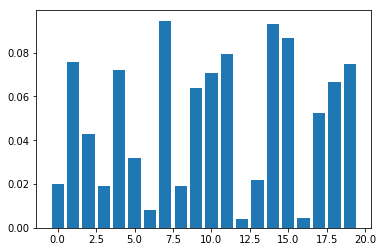

In [3]:
xx = PM.getVariable('x').level()
xx = xx/sum(xx)

%matplotlib inline
import matplotlib.pyplot as plt

plt.bar(np.arange(n), xx)
plt.show()

We can also verify that the total contribution of each assed towards total risk is proportional to the budgeting vector $b$, as required:

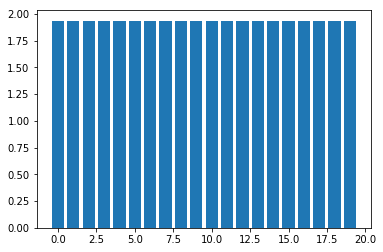

In [4]:
RC = xx * (np.dot(Sigma,xx))
plt.bar(np.arange(n), RC/b)
plt.show()

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed. For more information contact our [support](mailto:support@mosek.com). 